# Response time minimization - Finnmark police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

#### Finnmark police district
Finnmark is the country's northernmost police district, with a scattered population, great distances and a harsh climate. Finnmark police district is Norway's second largest, with an area of ​​48,631 km2. With a population of around 76,000, it is also the country's smallest police district in terms of population.


In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-30T20:03:15.080231+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandas    : 2.2.1
pandana   : 0.7
matplotlib: 3.8.3
geopandas : 0.14.3
numpy     : 1.26.4
osmnx     : 1.9.1



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [3]:
### Load road network from file
Finnmark_filepath = "../data/Finnmark/FinnmarkDriveImputed.graphml" # with travel time attribute
Finnmark_graph = ox.load_graphml(Finnmark_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
Finnmark_graph = ox.projection.project_graph(Finnmark_graph, to_crs='EPSG:32633') # project to local UTM zone
print(f"Type of Finnmark_graph: {type(Finnmark_graph)}")
print(f"CRS of Finnmark_graph:  {Finnmark_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(Finnmark_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of Finnmark_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Finnmark_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Finnmark_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


,,,osmid,name,highway,maxspeed,oneway,reversed,length,geometry,speed_kph,travel_time,bridge,ref,lanes,width,junction,access,tunnel,est_width
u,v,key,,,,,,,,,,,,,,,,,,
6649853654,6649853802,0,"[544799255, 321217143, 289301655, 479869082, 5...","[Šuolggajohnjálbmi, Áhpemohkki]","[unclassified, tertiary]",80,False,True,11112.143,"LINESTRING (896187.767 7724873.040, 896190.153...",80.000,500.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6649853802,6649857141,0,"[479870568, 479870565, 289301653]",Bieskkángeaidnu,tertiary,80,False,False,1274.426,"LINESTRING (897188.363 7732497.288, 897171.562...",80.000,57.300,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [6]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

,,,osmid,name,highway,maxspeed,oneway,reversed,length,geometry,speed_kph,travel_time,bridge,ref,lanes,width,junction,access,tunnel,est_width
u,v,key,,,,,,,,,,,,,,,,,,
6649853654,6649853802,0,"[544799255, 321217143, 289301655, 479869082, 5...","[Šuolggajohnjálbmi, Áhpemohkki]","[unclassified, tertiary]",80,False,True,11112.143,"LINESTRING (896187.767 7724873.040, 896190.153...",104.525,382.717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6649853802,6649857141,0,"[479870568, 479870565, 289301653]",Bieskkángeaidnu,tertiary,80,False,False,1274.426,"LINESTRING (897188.363 7732497.288, 897171.562...",104.525,43.893,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# recombining nodes and increased edges to MultiDiGraph format - obs, careful of project + plot bug
Finnmark_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [8]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Finnmark_polygon_path = "../data/Finnmark/FinnmarkCombinedPolygon.geojson"
Finnmark_polygon_gdf = gpd.read_file(Finnmark_polygon_path)
Finnmark_polygon_gdf = Finnmark_polygon_gdf.to_crs(Finnmark_graph.graph['crs']) # convert to same CRS as the road network

In [9]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Finnmark/FinnmarkPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Finnmark_graph.graph['crs']) # convert to same CRS as the road network

In [10]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


,id,population,geometry
0,28267507661000,2,"POLYGON ((826749.995 7660999.998, 826749.995 7..."
1,28265007661000,2,"POLYGON ((826499.995 7660999.998, 826499.995 7..."


### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [11]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1500, max_range=1550) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=400, max_range=405) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 401. Target range [400, 405], using population multiplier: 0.008347656250000002


,id,population,geometry,num_points
3497,28197507862500,374,"POLYGON ((819749.992 7862499.997, 819749.992 7...",3
417,28132507781500,187,"POLYGON ((813249.995 7781499.998, 813249.995 7...",2
443,28137507781750,183,"POLYGON ((813749.995 7781749.998, 813749.995 7...",2


In [12]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

,geometry
0,POINT (821620.809 7675736.149)
1,POINT (821544.615 7675846.854)
2,POINT (820329.016 7677103.809)


In [13]:
# print(f"Number of nodes: {len(nodes)}")
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=9.1e-12, simplification_tolerance=5.0, plot_results=False)

Density: Min: 2.240e-21 | Median: 5.597e-12 | Mean: 9.779e-12 | Max: 6.849e-11


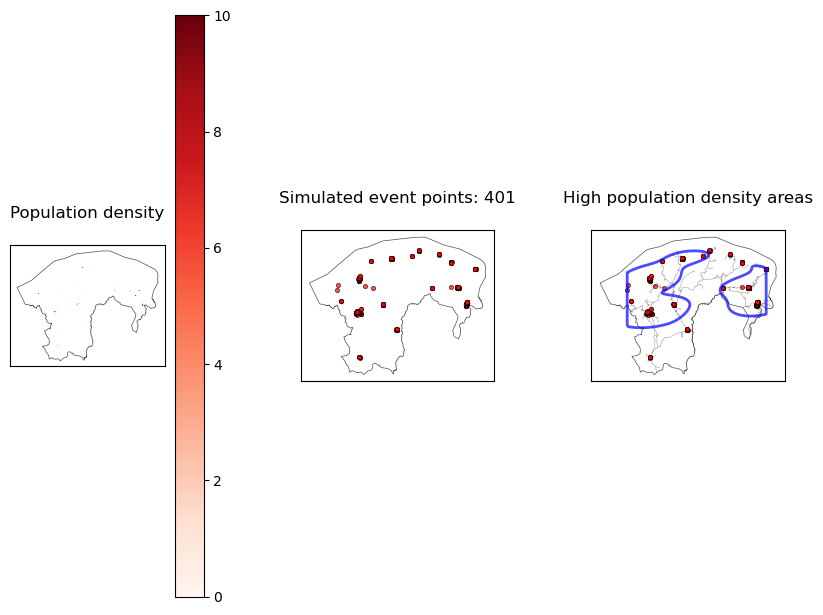

In [14]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Finnmark_polygon_gdf, population_gdf, event_points_gdf, high_pop_density_area, edges, set_vmax=10)

Population data is working, just so low population density that is hard to see on this plot.

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [15]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/Finnmark/FinnmarkNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

,y,x,street_count,lon,lat,highway,geometry,closeness_centrality,betweenness_centrality
osmid,,,,,,,,,
6649853654,7724873.040,896187.767,1,25.100,69.338,NaN,POINT (896187.767 7724873.040),0.000,0.000
6649853802,7732497.288,897188.363,3,25.157,69.404,NaN,POINT (897188.363 7732497.288),0.000,63364.000


### 2.2 Sample candidate points and filter out best candidate points

In [16]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 5287, nr of police car nodes: 100


,y,x,street_count,lon,lat,highway,geometry,closeness_centrality,betweenness_centrality
osmid,,,,,,,,,
10237715499,7806740.484,1076745.570,3,30.045,69.725,NaN,POINT (1076745.570 7806740.484),0.000,10569.000
7295497953,7799923.813,1075919.712,1,29.982,69.668,NaN,POINT (1075919.712 7799923.813),0.000,0.000


Input nr of car nodes: 100
Remaining nr of car nodes: 90, after discarding the 10 (10%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


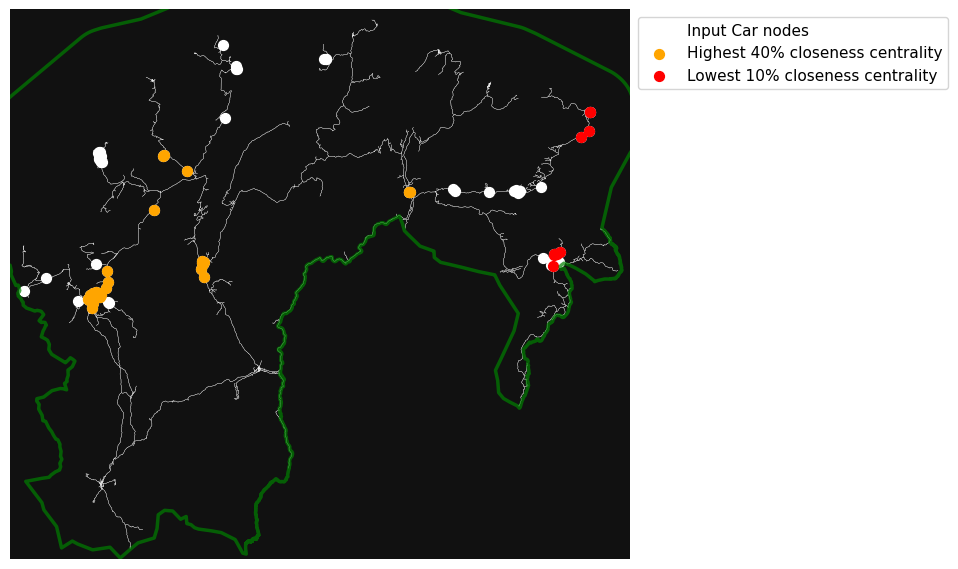

In [17]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Finnmark_polygon_gdf, 
                    top_percent=0.4, bottom_percent=0.10, input_graph=Finnmark_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 90
Remaining nr of car nodes: 63, after discarding the 27 (30%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


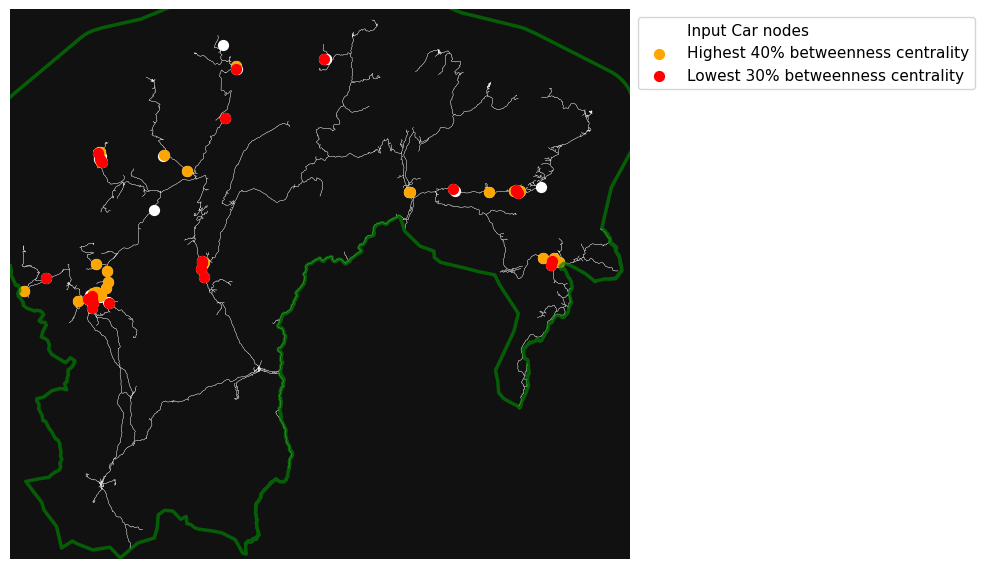

In [18]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Finnmark_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.30, input_graph=Finnmark_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 63
Remaining nr of car nodes: 21, after removing the 42 nodes that are within 5000 m of each other



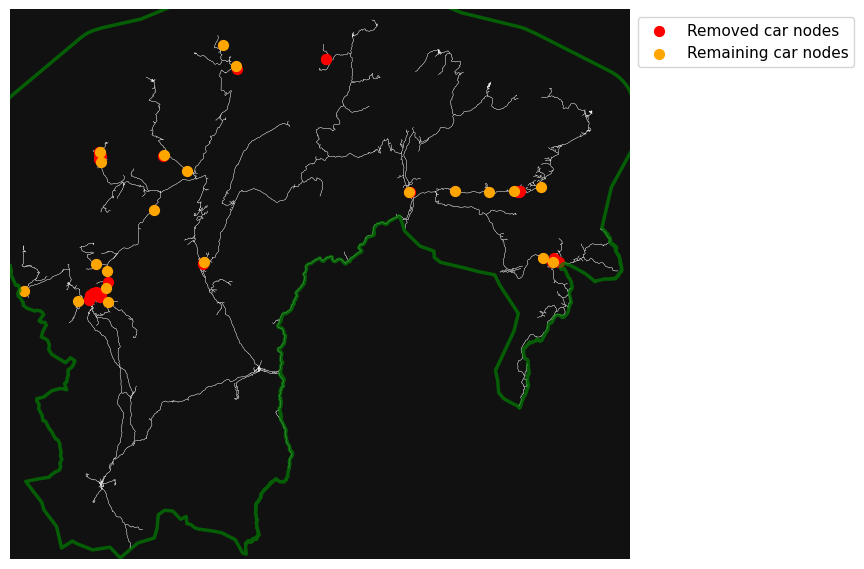

In [19]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Finnmark_polygon_gdf, 
                             min_distance=5000, input_graph=Finnmark_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [20]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
Finnmark_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Finnmark_network_pdna: {type(Finnmark_network_pdna)}")
print(f"Network nodes:")
Finnmark_network_pdna.nodes_df.head(2)

type of Finnmark_network_pdna: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
6649853654,896187.767,7724873.040
6649853802,897188.363,7732497.288


In [21]:
print(f"Network edges: ")
Finnmark_network_pdna.edges_df.head(2)

Network edges: 


,from,to,length,travel_time
0,6649853654,6649853802,11112.143,382.717
1,6649853802,6649857141,1274.426,43.893


Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [22]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Finnmark_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

,geometry,nearest_node,x,y
0,POINT (821620.809 7675736.149),2038906663.000,821615.262,7675627.102
1,POINT (821544.615 7675846.854),2038906691.000,821509.383,7675826.648


In [23]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Finnmark_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Finnmark_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([5870908506, 5870903679, 7295495532, 5421279356, 3163812528],
      dtype=int64)

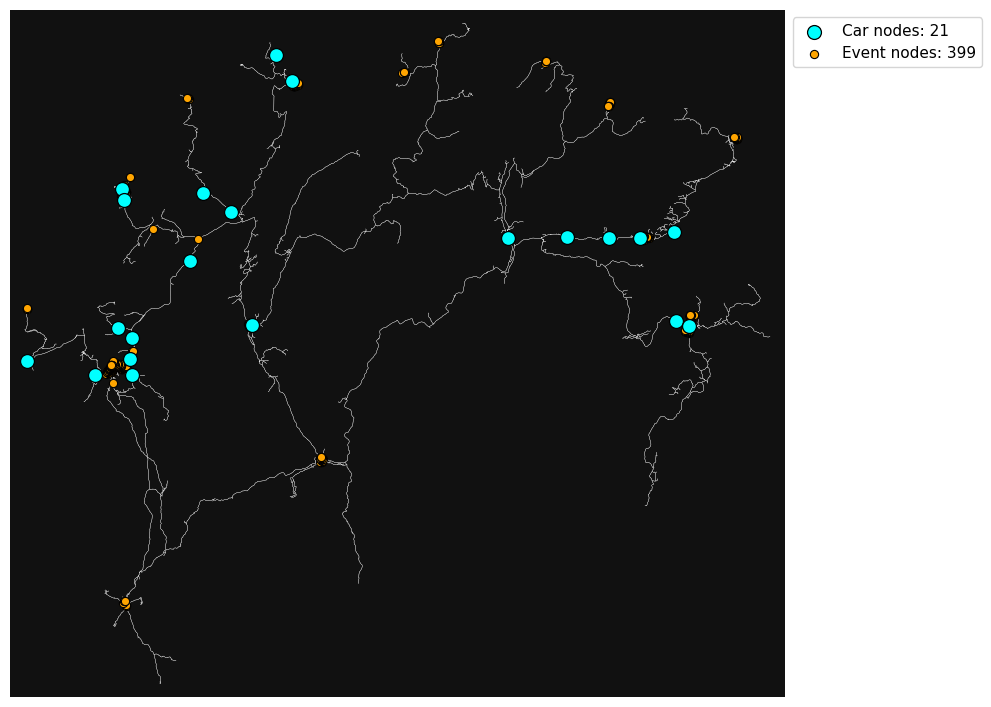

In [24]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(Finnmark_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [25]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [26]:
%%time
# travel time between each possible pair of car-event combination
distances = Finnmark_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = Finnmark_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

21 origins x 399 destinations = 8379 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [360620.089, 360902.553, 357962.721, 416786.316, 431451.242]
5 first origin-destination travel times [sec]: [12868.065, 12896.388, 12725.126, 15127.499, 16297.348]
CPU times: total: 172 ms
Wall time: 35.5 ms


In [27]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,8379.000,166.344,108.291,0.000,78.183,137.099,274.335,375.788


In [28]:
# Restructure the distances and travel times arrays into a DataFrame (CFinnmark Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head(2) # distances, travel times, car and event node ids

,distance,travel_time,carNodeID,eventNodeID
0,360620.089,12868.065,5870908506,2038906663
1,360902.553,12896.388,5870908506,2038906691


In [29]:
# Merge the CostMatrix with the nodes DataFrame to get the x, y coordinates of the car and event nodes
# The 'osmid' column in the nodes DataFrame is the same as the 'carNodeID' and 'eventNodeID' columns in the CostMatrix
nodes_flat = nodes.reset_index()
CostMatrix_extended = CostMatrix.copy()
CostMatrix_extended = CostMatrix_extended.merge(nodes_flat[['osmid', 'x', 'y']], left_on='carNodeID', right_on='osmid')
CostMatrix_extended = CostMatrix_extended.merge(nodes_flat[['osmid', 'x', 'y']], left_on='eventNodeID', right_on='osmid', suffixes=('_car', '_event'))
CostMatrix_extended.drop(columns=['osmid_car', 'osmid_event'], inplace=True)
CostMatrix_extended.head(2)

,distance,travel_time,carNodeID,eventNodeID,x_car,y_car,x_event,y_event
0,360620.089,12868.065,5870908506,2038906663,1039808.943,7842195.367,821615.262,7675627.102
1,360902.553,12896.388,5870908506,2038906691,1039808.943,7842195.367,821509.383,7675826.648


In [29]:
# Save cFinnmark matrix to CSV
CostMatrix.to_csv("../data/Finnmark/FinnmarkCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [30]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

,travel_time,carNodeID,eventNodeID
0,4679.494,2168868512,2038906663_1
1,4706.516,2168868512,2038906695_1


In [38]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
# margin = len(event_nodes_pdna) * 0.03 # 3% of all events
# CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
CAR_CAPACITY = 142
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 142 events per car
Filtering out 0% highest travel times - keeping only travel times <= 22511 sec, or 375.2 min
Original nr of pairs: 7581 | Filtered nr of pairs: 7581
Original max travel time: 22510.589 | Filtered max travel time: 22510.589


### 5.2 Setup LP problem

In [39]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 19
Number of events: 399
Number of decision variables: 7600
Number of constraints: 8000
Number of non-zero coefficients: 7600
Number of non-zero coefficients in the objective function: 7580
CPU times: total: 188 ms
Wall time: 441 ms


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).

In [40]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
Optimal police car locations found: 4/4 in 0.74 seconds: [5870902994 5815080977 7295459214   33990132]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 711905.8900 seconds, or 11865.10 minutes, or 197.75 hours
CPU times: total: 297 ms
Wall time: 1.05 s


### 5.6 Extract results for inspection

In [41]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/Finnmark/FinnmarkCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([5870902994, 5815080977, 7295459214, 33990132])
Car 5870902994 is assigned 83/142 events
Car 5815080977 is assigned 114/142 events
Car 7295459214 is assigned 60/142 events
Car 33990132 is assigned 142/142 events
Summing the events for each car gives 399 events, which should equal the total number of unique events: 399


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 19 | Optimal locations in solution: 4
- Events: 399 | Max event capacity per police car: 142

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 711906 sec | 11865.1 min | 197.75 hours

Car id: 5870902994 handles 83 events | Capacity: 58.45% | Total response time: 4323.42 min | Median: 47.03 min | Avg: 52.09 min
Car id: 5815080977 handles 114 events | Capacity: 80.28% | Total response time: 4622.39 min | Median: 8.72 min | Avg: 40.55 min
Car id: 7295459214 handles 60 events | Capacity: 42.25% | Total response time: 219.07 min | Median: 4.13 min | Avg: 3.65 min
Car id: 33990132 handles 142 events | Capacity: 100.00% | Total response time: 2700.22 min | Median: 6.22 min | Avg: 19.02 min


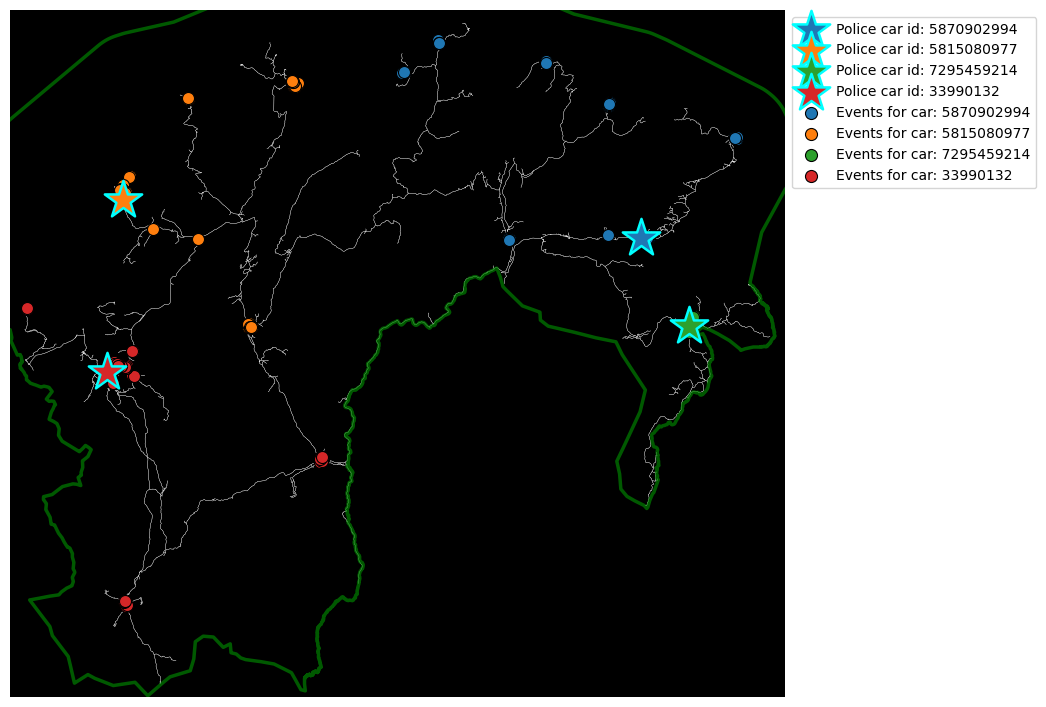

CPU times: total: 1.14 s
Wall time: 1.42 s


In [42]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(Finnmark_graph, Finnmark_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [47]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 120]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [48]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Finnmark_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=500, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 10.7 s
Wall time: 13.8 s


Isochrone polygons for the travel times: [20, 60, 120] minutes


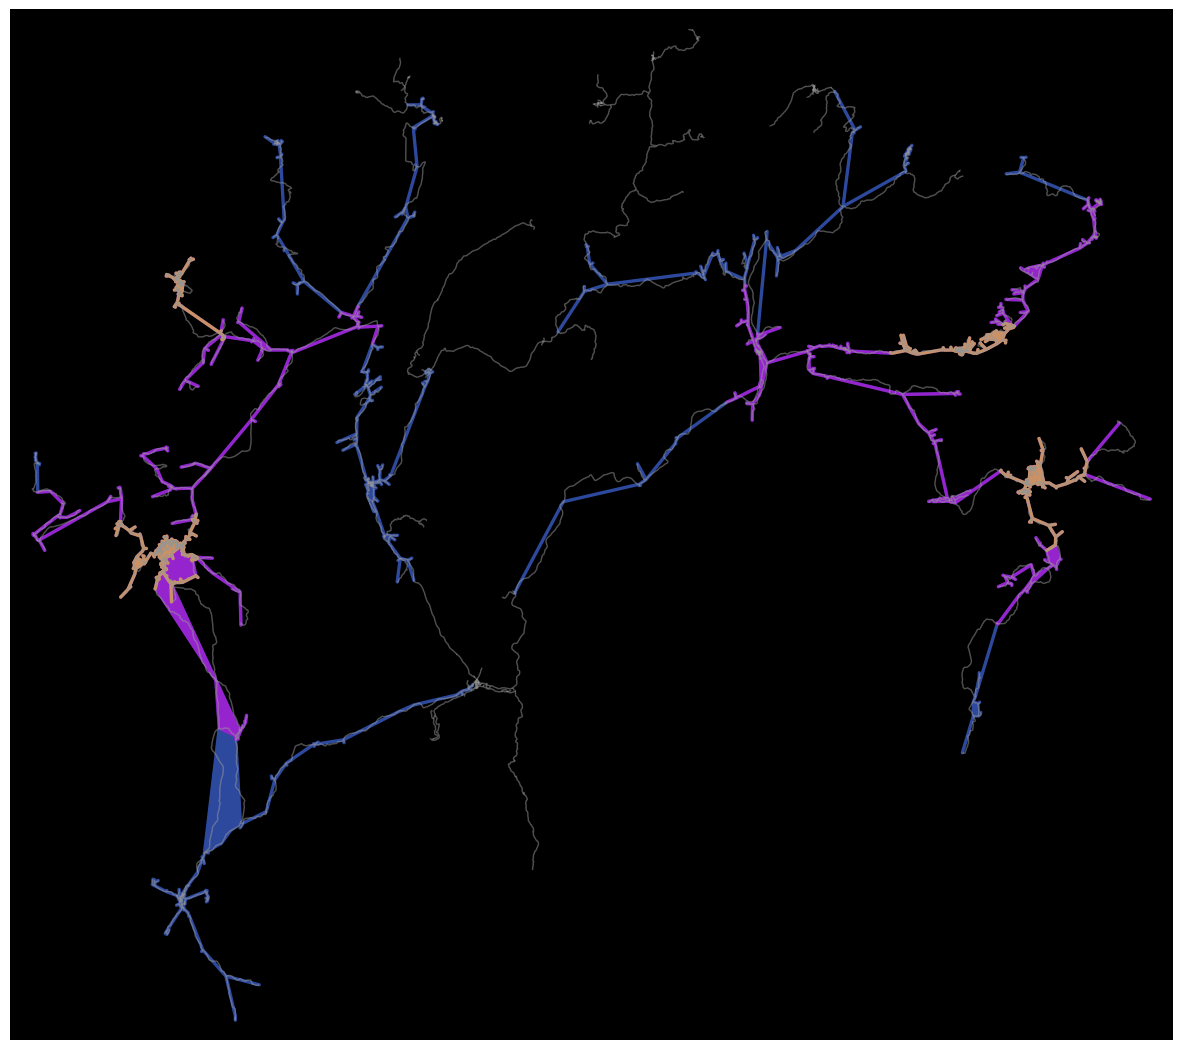

In [49]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Finnmark_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [50]:
%%time
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(Finnmark_graph, TRIP_TIMES, merged_isochrones, Finnmark_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 188 ms
Wall time: 483 ms
